# SETUP

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import torch
from tqdm import tqdm, trange
from transformers import AutoModel
from keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# GPU check
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1050 Ti


# FUNCTIONS

In [3]:
"""
For dealing with large amounts of data, a GPU is much faster

The resulting embedding matrix is a three-dimensional tensor corresponding to                 [Sentence][Words][Embeddings]
embeddings[5][4][:] is thus the embedding of the fourth word in the fifth sentence
"""

def get_embeddings_with_gpu(data_matrix, mask_matrix):
    # Load the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #print(f"Using device: {torch.cuda.get_device_name(0)}")

    # Set the model to use the device
    model.cuda()

    # Move the data onto the GPU
    data_matrix = data_matrix.to(device)
    mask_matrix = mask_matrix.to(device)

    # Generate embeddings
    matrix_embedding = model.forward(input_ids=data_matrix,
        attention_mask=mask_matrix,
        head_mask=None)[0]
    #print(f"Embedding generated with shape {batch_embedding.shape}")

    # Make it an ordinary np array instead of a torch
    matrix_embedding = np.array(matrix_embedding.tolist())

    return matrix_embedding

#Keep amount of samples low to not overwhelm the gpu
#get_embeddings_with_gpu(data_tensor_matrix[:10], mask_tensor_matrix[:10])

In [4]:
"""
Most people won't be able to load all the data onto the GPU at once however, so it's better   to do it in batches.
(50 input sentences take 2803MB on my computer, for example). Though this depends on the dimensionality/sentence_length you use, naturally

This method batchifies and stitches together the batches
"""
def get_embeddings_with_gpu_batch(data_matrix, mask_matrix, batch_size):
    num_items = data_matrix.shape[0]
    num_loops = int(np.ceil(num_items/batch_size))

    start = 0
    end = batch_size
    data_holder = []

    for i in trange(num_loops):
        # Split the data into batches
        data_batch = data_matrix[start:end]
        mask_batch = mask_matrix[start:end]

        #Get the embedding for the batch
        batch_embedding = get_embeddings_with_gpu(data_batch, mask_batch)

        data_holder.append(batch_embedding)

        #Move to next batch
        start += batch_size
        end += batch_size

    # Merge the batches we've generated
    embedding_matrix = np.vstack(data_holder)

    print(f"Final embedding generated with shape {embedding_matrix.shape}")

    return embedding_matrix

#embedding_matrix = get_embeddings_with_gpu_batch(data_tensor_matrix[:200], mask_tensor_matrix[:200], 50)


In [5]:
"""
Split data into train and test sets by the given ratio.
Validation sets are not needed, those we get for free with keras models
"""
def split_data(percentage_to_train_on, input_data, output_data):
    ratio = percentage_to_train_on

    split = int(np.ceil(ratio*input_data.shape[0]))

    train_x = input_data[:split]
    train_y = output_data[:split]

    test_x = input_data[split:]
    test_y = output_data[split:]

    return train_x, train_y, test_x, test_y


# LOAD DATA

In [6]:
#This is the latest!
def load_data_from_start2():
    #Load the data
    sentences = np.load("../data/sentence_ints.npy")
    attentions = np.load("../data/attention_ints.npy")
    labels = np.load("../data/label_ints.npy")
    label_list = np.load("../data/label_list.npy")
    return sentences, attentions, labels, label_list

sentences, attentions, labels, label_list = load_data_from_start2()


In [7]:
# Load the model and tokenizer
model = AutoModel.from_pretrained('KB/albert-base-swedish-cased-alpha')
tokenizer = AutoTokenizer.from_pretrained("KB/albert-base-swedish-cased-alpha")

#Update the tokenizer with our labels (which do not exist in the normal vocabulary)
tokenizer.add_tokens(label_list.tolist())

#Inform the model that we've updated the vocab
model.resize_token_embeddings(len(tokenizer))

Embedding(50030, 128)

In [8]:
# Let's test stuff with just a subset of the data
sentences, attentions, labels = sentences[:5000], attentions[:5000], labels[:5000]

#Convert to tensors
sentences, attentions = torch.tensor(sentences), torch.tensor(attentions)

In [9]:
# Generate embeddings
embedding_matrix = get_embeddings_with_gpu_batch(sentences, attentions, 25)

100%|██████████| 200/200 [02:14<00:00,  1.48it/s]


Final embedding generated with shape (5000, 100, 768)


In [10]:
#We need to one-hot encode the output labels for use with the classifier

#Flatten the label matrix
long_single_token_label_list = labels.reshape(-1,)

#one-hot encode all labels
dummy_variable_representation = pd.get_dummies(long_single_token_label_list)

#Make a dummy-variable-index => token dict for later use
dummyIndex_label_dict = {}
for i, column in enumerate(dummy_variable_representation):
    dummyIndex_label_dict[i] = tokenizer.decode(column)
    

#Reshape the one-hot encoding so we get it in the correct shape, that is, grouped on a sentence level
label_matrix = dummy_variable_representation.values.reshape(labels.shape[0], labels.shape[1], -1)

In [11]:
#Train/test split it
ratio = 0.8
train_x,train_y,test_x,test_y = split_data(ratio, embedding_matrix, label_matrix)

print(train_y.shape, test_y.shape)
print(train_x.shape, test_x.shape)

(4000, 100, 24) (1000, 100, 24)
(4000, 100, 768) (1000, 100, 768)


# TRAIN ALBERT

### Create classification layer

To ablate the fine-tuning approach, we apply the
feature-based approach by extracting the activations from one or more layers without fine-tuning
any parameters of BERT. These contextual embeddings are used as input to a randomly initialized two-layer 768-dimensional BiLSTM before
the classification layer.



In [12]:
from keras.layers import LSTM, Bidirectional, TimeDistributed, Dropout, Dense
from keras.models import Model, Input
def naive_bilstm_model():   
    #Define the input shape. Each datapoint is a sentence consisting of seqlength words, each word 784dims
    input = Input(shape=(train_x.shape[1], train_x.shape[2]))
    # Pass it through a bidirectional lstm
    model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(input)
            
    # add a timedistributed layer
    out = TimeDistributed(Dense(train_y.shape[2], activation="softmax"))(model)  # softmax output layer
    
    model = Model(input, out)
    
    # Compile it
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    print(model.summary())
    return model


In [13]:
# Train the model, setting aside 10% data for validation
classifier = naive_bilstm_model()
def train_model():
    history = classifier.fit(
        train_x,
        train_y,
        epochs=5,
        batch_size=50,
        validation_split=0.1)
    return history

history = train_model()
print('\nhistory dict:', history.history.keys())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 768)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          695200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 24)           4824      
Total params: 700,024
Trainable params: 700,024
Non-trainable params: 0
_________________________________________________________________
None
Train on 3600 samples, validate on 400 samples
Epoch 1/5
3600/3600 [==============================] - 17s 5ms/step - loss: 0.3980 - accuracy: 0.9055 - val_loss: 0.1946 - val_accuracy: 0.9530
Epoch 2/5
3600/3600 [==============================] - 14s 4ms/step - loss: 0.1183 - accuracy: 0.9705 - val_loss: 0.1194 - val_accuracy: 0.9682
Epoch 3/5
3600/3600 [======================

## Training history

In [14]:
def create_history_df(history):
    training_df = pd.DataFrame()
    for metric in history.history.keys():
        training_df[metric] = history.history[metric]
    return training_df

history_df = create_history_df(history)

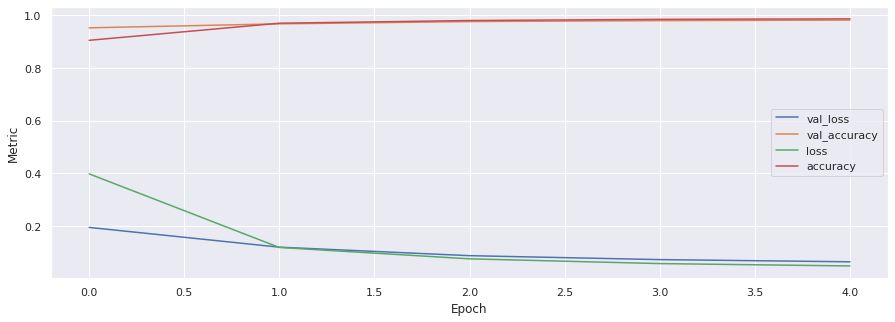

In [15]:
sns.set()
fig, ax = plt.subplots(figsize=(15,5))
history_df.plot(ax=ax)
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.show()

# Evaluate

In [16]:
print('\n# Evaluate on test data')
results = classifier.evaluate(train_x, train_y)
for i, metric in enumerate(classifier.metrics_names):
    print(f"{metric}: {results[i]}")


# Evaluate on test data
4000/4000 [==============================] - 12s 3ms/step
loss: 0.04542950388789177
accuracy: 0.9876750111579895


## Confusion Matrix

In [17]:
def remap(matrix):
    """
    Utility function to take one-hot encoded labels and return the label with the higest probability
    """
    
    #Switch index to label
    def switcher(x):
        return dummyIndex_label_dict[x]
    
    #Get the index along the second axis (the one-hot encoding) with the highest value
    predicted_index = pd.DataFrame(np.argmax(matrix, axis=2))
    
    #Use our dictionary to map this index to the class
    label_representation = predicted_index.applymap(switcher)

    return label_representation

In [18]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix

In [19]:
#Get the predicted classes for the test set
prediction_probabilities = classifier.predict(test_x)

predicted_classes = remap(prediction_probabilities)
true_classes = remap(test_y)

In [20]:
# Unravel it
predicted_classes = predicted_classes.values.reshape(-1,1)
true_classes = true_classes.values.reshape(-1,1)

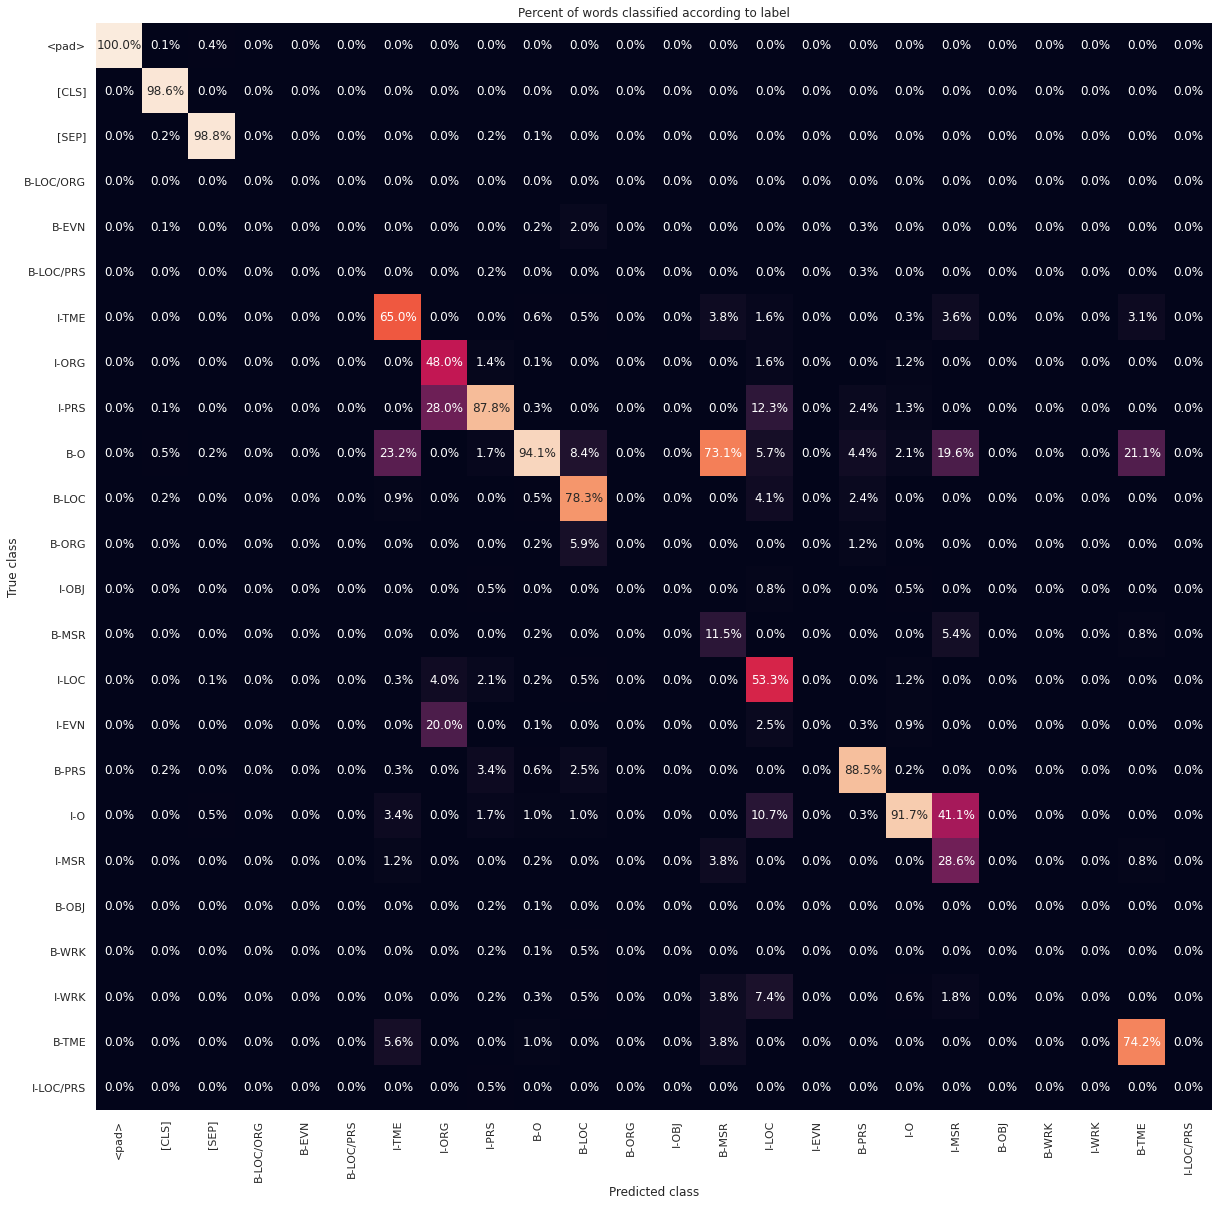

In [21]:
# The scikit confusion function also takes a list of labels. The generated confusion matrix will consist of the elements of this list, in the order they appear
labels = list(dummyIndex_label_dict.values())

# We are great at padding, but that isn't super-interesting
#labels.remove('<pad>')

#Generate a confusion matrix
cmatrix = confusion_matrix(y_true=true_classes, y_pred=predicted_classes, labels = labels)

#Use pandas for plotting purposes
cmatrix = pd.DataFrame(cmatrix, columns=labels, index=labels)

# The absolute number of things retrieved isn't as interesting as the relative retrival, so we normalize along the x-axis
cmatrix = cmatrix.apply(lambda x: x/x.sum(), axis = 0)

#Remove Nans
cmatrix = cmatrix.fillna(0)

#The confusion matrix is defined such that each row corresponds to a true label, each column is predicted label
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(cmatrix, ax = ax, annot=True, fmt=".1%", cbar=False)
ax.set_xlabel("Predicted class")
ax.set_ylabel("True class")
plt.title("Percent of words classified according to label")
plt.show()

## Generate Recall, Precision, F1-score for each label

In [22]:
from sklearn.metrics import classification_report

report = classification_report(y_true=true_classes, y_pred=predicted_classes, labels = labels, output_dict=True, zero_division=0)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
<pad>,0.999581,0.999914,0.999747,81123.0
[CLS],0.986125,0.995000,0.990543,1000.0
[SEP],0.987817,0.973000,0.980353,1000.0
B-LOC/ORG,0.000000,0.000000,0.000000,0.0
B-EVN,0.000000,0.000000,0.000000,29.0
B-LOC/PRS,0.000000,0.000000,0.000000,3.0
I-TME,0.650155,0.686275,0.667727,306.0
I-ORG,0.480000,0.173913,0.255319,69.0
I-PRS,0.877586,0.820968,0.848333,620.0
B-O,0.941215,0.978777,0.959629,11827.0


## Test albert and classifier on single sentences

In [23]:
def format_single_sentence(s):
    """
    Takes a string and formats it for use with the ALBERT model used in this project
    Also returns the attention mask
    """
    pad_symbol = tokenizer.encode('<pad>', add_special_tokens=False)
    input_array = pad_symbol*100

    # Encode our sentence
    encoding = tokenizer.encode(s)

    #Overwrite our dummy array
    input_array[:len(encoding)] = encoding

    #Adjust dimensionality, make it a tensor
    input_tensor = torch.tensor(np.array(input_array).reshape(1,-1))
    
    attention = np.array(input_array) != 0
    attention_tensor = torch.tensor(attention.reshape(1,-1))
    return input_tensor, attention_tensor
    
#inp, att = format_single_sentence('hi')

In [24]:
def classify_single_sentence(sentence_tensor, attention_tensor):
    """
    Given input formatted for use with the ALBERT model, generates embeddings and uses them with a classifier to generate prediction for each original word
    Returns a dataframe containing token, predicted token, and certainity/probability
    """
    embedding = get_embeddings_with_gpu_batch(sentence_tensor, attention_tensor, 1)
    
    #Predict using the embeddings
    prediction_probabilities = classifier.predict(embedding)

    #Given these probabilities, get the predicted class for each word
    predicted_labels = remap(prediction_probabilities)

    #Get the confidence for our predictions as well
    certainity = prediction_probabilities.max(axis=2)

    #Get the input token array we used
    sentence_tokens = tokenizer.convert_ids_to_tokens(np.array(sentence_tensor).reshape(-1,))

    #Put it all into a dataframe for an easy-to-read output
    pretty_df = pd.DataFrame(columns = ['Word', 'Predicted_Label', 'Certainity'])

    pretty_df['Word'] = sentence_tokens
    pretty_df['Predicted_Label'] = predicted_labels.T
    pretty_df['Certainity'] = certainity.T
    
    return pretty_df

In [25]:
def NER(sentence):
    """
    Shorthand function for taken any sentence and tesing the model/classifier on it
    """
    sentence_tensor, attention_tensor = format_single_sentence(sentence)
    results = classify_single_sentence(sentence_tensor, attention_tensor)
    return results

In [26]:
s = "Har du läst Tusen och en Natt, en bok inte skriven i Sverige av Shaherazade"
NER(s).head(20)

100%|██████████| 1/1 [00:00<00:00, 30.46it/s]

Final embedding generated with shape (1, 100, 768)


,Word,Predicted_Label,Certainity
0,[CLS],[CLS],0.991368
1,▁Har,B-O,0.993439
2,▁du,B-O,0.992228
3,▁läst,B-O,0.985059
4,▁Tusen,B-O,0.640924
5,▁och,B-O,0.870249
6,▁en,B-O,0.885259
7,▁Natt,B-O,0.713308
8,",",B-O,0.993152
9,▁en,B-O,0.994093


## Test on sentence from SUC

In [27]:
#Select a sentence
select = 555

# Get the original sentence
sentence = np.array(sentences[select])
sentence_tokens = np.array(tokenizer.convert_ids_to_tokens(sentence))

# Get the ground truth labels
one_hot_truth = label_matrix[select].reshape(1,100,-1)
gt_labels = remap(one_hot_truth)

#Get the embedding matrix we generated for the sentence
sentence_embedding = embedding_matrix[select].reshape(1,100,-1)

#For each word, obtain the probabilities for each class
prediction_probabilities = classifier.predict(sentence_embedding)

#Given these probabilities, get the predicted class for each word
predicted_labels = remap(prediction_probabilities)

#Get the confidence for our predictions as well
certainity = prediction_probabilities.max(axis=2)


#Put it all into a dataframe for an easy-to-read output
pretty_df = pd.DataFrame(columns = ['Word', 'Predicted_Label', 'True_Label', 'Certainity'])

pretty_df['Word'] = sentence_tokens
pretty_df['Predicted_Label'] = predicted_labels.T
pretty_df['True_Label'] = gt_labels.T
pretty_df['Certainity'] = certainity.T


pretty_df.head(20)

,Word,Predicted_Label,True_Label,Certainity
0,[CLS],[CLS],[CLS],0.988105
1,▁Under,B-TME,B-TME,0.686310
2,▁förra,I-TME,I-TME,0.489081
3,▁sommaren,I-TME,I-TME,0.686397
4,▁hade,B-O,B-O,0.994673
5,▁han,B-O,B-O,0.991287
6,▁långa,B-O,B-O,0.991132
7,▁samtal,B-O,B-O,0.980085
8,▁med,B-O,B-O,0.996702
9,▁sin,B-O,B-O,0.997573
